In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
#import logomaker as lm
from Bio.Seq import Seq
from Bio import motifs
from Bio.Alphabet import generic_dna

## Part 1: Generate sequences

In [2]:
#Set some values for the sequences we'll generate:
bases = ['A', 'T', 'C', 'G']
seq_length = 100
number_of_seq = 1000

#The original 'gene' is a random nucleotide sequence:
start_sequence = random.choices(bases, k=seq_length)
#print('The original "gene":',''.join(start_sequence))

#Set the mutation and variation rate:
variation_rate = .2
n_variantions = int(round(variation_rate * seq_length))

#Select random places for variation
var_places = np.random.randint(0, seq_length, size=n_variantions)

#Select random places for mutation (DIFFERENT from variation!)
n_mutations = 3
mutation_pos = np.random.choice(np.setdiff1d(np.arange(seq_length),var_places, assume_unique=True), n_mutations)
print("Is the position for the mutation in the varablie positions? (Should be False):", mutation_pos in var_places)
print(f'Mutation will occur at position {mutation_pos} in the starting sequence')

#Select a base that will be the "mutated" base.
#We need to check if these is the same or not with the original base in the original gene.
#This way we make sure it's "mutated"

mutated_bases = []
for pos in mutation_pos:
    og_base = start_sequence[pos]
    mu_base = random.choice([base for base in bases if base != og_base]) #Pick a different base for that position
    mutated_bases.append(mu_base)
    
print(mutated_bases)


#def pick_mutation_positions(mutation_pos, fixed_base, n):
#    mutation_pos = np.random.choice(np.setdiff1d(np.arange(seq_length),var_places, assume_unique=True), n)

#print("Check if fixed_base is different:", check_base(mutation_pos=mutation_pos, fixed_base=fixed_base))

#check = fixed_base != start_sequence[mutation_pos]
#print('Are original base and new mutated base different?:', check)

#print(f'Position {mutation_pos} in the starting sequence will be changed to {fixed_base} from {start_sequence[mutation_pos]}')

print("Starting with sequence:",''.join(start_sequence))

#Each point mutation has preditermined probabilities for a given base occuring at that position.
probs = [np.random.dirichlet(np.ones(4),size=1).flatten() for point in range(n_variantions)]

#For every sequence we have to pick a base for every point mutation given those probabilities

#Healthy sequence: fixed point mutations with probability of occurence represent a "varying healthy gene"

def healthy_gen(seq):
    for i,p in enumerate(var_places):
        base = random.choices(bases, weights=probs[i])[0]
        seq[p] = base
    return seq

#Mutated sequence: Similarly varying as the healthy sequence
#BUT contains either one or all of the mutated positions
def mutated_gen(seq):
    for i, p in enumerate(var_places):
        base = random.choices(bases, weights=probs[i])[0]
        seq[p] = base
        
    n_muts = random.choice(np.arange(1,n_mutations+1))
    for mut in range(n_muts):
        for pos, base in random.sample(list(zip(mutation_pos, mutated_bases)),1):
            seq[pos] = base 
    return seq

Is the position for the mutation in the varablie positions? (Should be False): False
Mutation will occur at position [61 69 68] in the starting sequence
['G', 'A', 'A']
Starting with sequence: CCCTTGCATCGCAAGGGAGCTAACTGCCGTGCGCAATAGGGATAAGGCGACAACGCGATCTATTCGTGGTGTAGCCGTTGTTTTTTATTTCCTCCTTACG


/Users/mattijsbeirinckx/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [3]:
#This represent the sequences as we would get them from a fasta file
negatives = [''.join(healthy_gen(seq=start_sequence[:])) for i in range(number_of_seq)]
positives = [''.join(mutated_gen(seq=start_sequence[:])) for i in range(number_of_seq)]

print(f'\nVariations occur at {var_places}\n')
blank_var = list('_'*seq_length)
for pos in var_places:
    blank_var[pos]='V'
print(''.join(blank_var))

for i in range(5):
    print(negatives[i])

print(f'\nMutations occur at {mutation_pos}\n')
blank_mut = list('_'*seq_length)
for pos in var_places:
    blank_mut[pos]='V'
for pos in mutation_pos:
    blank_mut[pos]='M'
print(''.join(blank_mut))

for i in range(5):
    print(positives[i])


Variations occur at [27 21 66 74 13 23 63  4 32 47 51 32  1 28 93 46 11 27 51 85]

_V__V______V_V_______V_V___VV___V_____________VV___V___________V__V_______V__________V_______V______
CCCTCGCATCGAAGGGGAGCTAATTGCGATGCACAATAGGGATAAGGCGACAACGCGATCTATACGTGGTGTAGGCGTTGTTTTTTATTTCCTCCTTACG
CTCTCGCATCGTATGGGAGCTGAGTGCACTGCGCAATAGGGATAAGGAGACTACGCGATCTATCCGCGGTGTAGCCGTTGTTTTTCATTTCCTACTTACG
CTCTCGCATCGAACGGGAGCTGAATGCACTGCACAATAGGGATAAGGCGACAACGCGATCTATACGCGGTGTAGACGTTGTTTTTCATTTCCTACTTACG
CTCTCGCATCGAATGGGAGCTCAATGCAATGCACAATAGGGATAAGGTGACAACGCGATCTATCCGAGGTGTAGACGTTGTTTTTTATTTCCTACTTACG
CGCTCGCATCGTACGGGAGCTGATTGCACTGCTCAATAGGGATAAGGTGACTACGCGATCTATCCGCGGTGTAGACGTTGTTTTTTATTTCCTTCTTACG

Mutations occur at [61 69 68]

_V__V______V_V_______V_V___VV___V_____________VV___V_________M_V__V_MM____V__________V_______V______
CGCTCGCATCGGATGGGAGCTGAGTGCACTGCACAATAGGGATAAGGTGACCACGCGATCTATCCGCGATGTAGACGTTGTTTTTCATTTCCTGCTTACG
CTCTCGCATCGGATGGGAGCTCAATGCACTGCGCAATAGGGATAAGCCGACAACGCGATCTGTACGCGAAGTAGGC

In [4]:
#FLANKING REGIONS TO MAKE IT HARDER
def flanking_regions(sequence, flank=10):
    flank_left = random.choices(bases, k=flank)
    flank_right = random.choices(bases, k=flank)
    
    new_seq = ''.join(flank_left)+sequence+''.join(flank_right)
    return new_seq


negatives_flanked = [flanking_regions(sequence=seq) for seq in negatives]
positives_flanked = [flanking_regions(sequence=seq) for seq in positives]

## Part 2: Prepare data for input in CNN

In [5]:
#Data augmentation using the reverse complement
rc_negatives = [str(Seq(x, alphabet=generic_dna).reverse_complement()) for x in negatives_flanked]
rc_positives = [str(Seq(x, alphabet=generic_dna).reverse_complement()) for x in positives_flanked]
negatives_augmented = negatives_flanked+rc_negatives
positives_augmented = positives_flanked+rc_positives
print(len(negatives_augmented), len(positives_augmented))

sequences = negatives_augmented + positives_augmented
labels = list(np.zeros(len(negatives_augmented))) + list(np.ones(len(positives_augmented)))

2000 2000


In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#Create data input for CNN
#From https://github.com/NikolayOskolkov/DeepLearningAncientDNA/blob/master/DeepLearningAncientDNA.ipynb

integer_encoder = LabelEncoder() 
one_hot_encoder = OneHotEncoder()  
input_features = []

for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('\nOne hot encoding of Sequence #1:\n',input_features[0].T)



#Same for labels

one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('\nLabels:\n',labels.T)
print('\nOne-hot encoded labels:\n',input_labels.T)

Example sequence
-----------------------
DNA Sequence #1:
 GAAGCGCATC ... GTCGGAACTA

One hot encoding of Sequence #1:
 [[0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

Labels:
 [[0. 0. 0. ... 1. 1. 1.]]

One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [7]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

print(np.sum(train_labels, axis = 0), 
      np.sum(test_labels, axis = 0))

[1476. 1524.] [524. 476.]


In [8]:
print('Training features shape:', train_features.shape)
print('Training labels shape:', train_labels.shape)
print('Testing features shape:', test_features.shape)
print('Testing labels shape:', test_labels.shape)

input_shape = (train_features.shape[1], 4)
print('Feature input shape:', input_shape)


train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))


#Shuffle and Bacth the dataset? TODO
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Training features shape: (3000, 120, 4)
Training labels shape: (3000, 2)
Testing features shape: (1000, 120, 4)
Testing labels shape: (1000, 2)
Feature input shape: (120, 4)


## Part 3: Create and Train the CNN model 

In [9]:
from tensorflow.keras.layers import MaxPool1D,Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta

In [10]:
#Try a super simple model with 1D convolution (The problem is trivial...)
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=4, padding='same', 
                 input_shape=input_shape, activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 120, 10)           170       
_________________________________________________________________
dropout (Dropout)            (None, 120, 10)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2402      
Total params: 2,572
Trainable params: 2,572
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(train_dataset, epochs=10, 
                    validation_data=test_dataset)

Epoch 1/10
150/150 [==============================] - 3s 17ms/step - loss: 0.4935 - accuracy: 0.7583 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
150/150 [==============================] - 1s 6ms/step - loss: 0.2292 - accuracy: 0.9237 - val_loss: 0.1175 - val_accuracy: 1.0000
Epoch 3/10
150/150 [==============================] - 1s 7ms/step - loss: 0.1463 - accuracy: 0.9533 - val_loss: 0.0708 - val_accuracy: 0.9950
Epoch 4/10
150/150 [==============================] - 1s 7ms/step - loss: 0.1124 - accuracy: 0.9640 - val_loss: 0.0433 - val_accuracy: 1.0000
Epoch 5/10
150/150 [==============================] - 1s 7ms/step - loss: 0.0885 - accuracy: 0.9733 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 6/10
150/150 [==============================] - 1s 6ms/step - loss: 0.0706 - accuracy: 0.9797 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 7/10
150/150 [==============================] - 1s 6ms/step - loss: 0.0613 - accuracy: 0.9823 - val_loss: 0.0155 - val_accuracy: 0.99

## Part 4: Evaluate the model

50/50 - 0s - loss: 0.0099 - accuracy: 1.0000


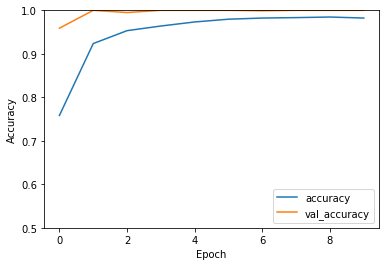

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)